# Cobra's approach to linear regression

Cobra requires the usual Python packages for data science, such as numpy, pandas and scikit-learn. These packages, along with their versions are listed in requirements.txt and can be installed using pip.

This section we will walk you through all the required steps to build a predictive linear regression model using **Cobra**. All classes and functions used here are well-documented. In case you want more information on a class or function, run `help(function_or_class_you_want_info_from)`.

Building a good model involves three steps:

1. **Preprocessing**: properly prepare the predictors (a synonym for “feature” or variable that we use throughout this tutorial) for modelling.

2. **Feature selection**: automatically select a subset of predictors which contribute most to the target variable or output in which you are interested.

3. **Model evaluation**: once a model has been build, a detailed evaluation can be performed by computing all sorts of evaluation metrics.

Let's dive in!
***

## California house price prediction

- Basetable: sklearn dataset
- Goal: Predict the average house price for a house block

In [1]:
import json
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.api.types import is_datetime64_any_dtype
from sklearn import metrics
from sklearn.datasets import fetch_california_housing

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

In [2]:
from cobra import __version__

from cobra.preprocessing import PreProcessor

from cobra.model_building import univariate_selection
from cobra.model_building import ForwardFeatureSelection
# from cobra.model_building import LinearRegressionModel

from cobra.evaluation import RegressionEvaluator
from cobra.evaluation import generate_pig_tables
from cobra.evaluation import plot_univariate_predictor_quality
from cobra.evaluation import plot_correlation_matrix
from cobra.evaluation import plot_performance_curves
from cobra.evaluation import plot_variable_importance
from cobra.evaluation import plot_incidence

/home/jano/anaconda3/envs/tutorial/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's take a look at the dataset! Note, in the dataset's description below, that the samples in the population are not individual houses, but blocks of houses.

In [3]:
data = fetch_california_housing()
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df.loc[:, data.target_names[0]] = data.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<u>Units: </u>
- MedInc: 10k USD/year  
- HouseAge: years  
- MedHouseVal: 100k USD



Cobra does not support *category*-typed variables, they need to be converted to object dtypes. Since we have none, this is not necessary.

In [5]:
df.dtypes

MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

## Data preprocessing

#### The first part focuses on preparing the predictors for modelling by:

1. Defining the ID column, the target, discrete and continuous variables.

2. Splitting the dataset into training, selection and validation datasets.

3. Binning continuous variables into discrete intervals.

4. Replacing missing values of both categorical and continuous variables (which are now binned) with an additional “Missing” bin/category.

5. Regrouping categories in new category “other”.

6. Replacing bins/categories with their corresponding average of the target values.

Most datasets at customers contain an ID column, such as the customer ID. Therefore, Cobra needs to know which column this is, such that it is not used as a variable in the model.
This dataset does not have an ID column, so we create one, based on the dataframe index. We will pass this column to Cobra then.

In [6]:
df["id"] = df.index + 1
id_col = "id"
id_col

'id'

The dataset's target (the value to predict) is the median house value.

In [7]:
target_col = data.target_names[0]
target_col

'MedHouseVal'

In [8]:
df[target_col].describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64

We need to find out which variables are categorical (discrete) and which are continuous.

Discrete variables are definitely those that contain strings.

We know from manual inspection that all of them are continuous, this piece of code will double check if our assumptions are correct.

In [9]:
col_dtypes = df.dtypes
discrete_vars = [col for col in col_dtypes[col_dtypes==object].index.tolist() if col not in [id_col, target_col]] 
discrete_vars

[]

Next, we also check for numerical columns that only contain a few different values, thus to be interpreted as discrete, categorical variables.

In [10]:
for col in df.columns:
    if col not in discrete_vars and col not in [id_col, target_col]: # omit discrete because a string, and target
        val_counts = df[col].nunique()
        if val_counts > 1 and val_counts <= 10: # the column contains less than 10 different values
            print(col)

No variables are printed, so we don't need to include anymore variables in the discrete variables. So we are indeed working with only continuous predictors.

In [11]:
continuous_vars = list(
    set(df.columns)
    - set(discrete_vars) 
    - set([id_col, target_col]))
continuous_vars  

['Population',
 'AveBedrms',
 'MedInc',
 'AveOccup',
 'Latitude',
 'Longitude',
 'AveRooms',
 'HouseAge']

Now, we can prepare **Cobra's PreProcessor** object.

In [12]:
model_type = "regression"

# using all Cobra's default parameters for preprocessing here
preprocessor = PreProcessor.from_params(
    model_type=model_type
)

# these are all available options: help(PreProcessor.from_params)

The target encoder's additive smoothing weight is set to 0. This disables smoothing and may make the encoding prone to overfitting. Increase the weight if needed.


Split the data into train-selection-validation sets.

In [13]:
random.seed(13)
basetable = preprocessor.train_selection_validation_split(
    data=df,
    train_prop=0.60,
    selection_prop=0.20,
    validation_prop=0.20
)

Fit the preprocessor pipeline.

In [14]:
preprocessor.fit(
    basetable[basetable["split"]=="train"],
    continuous_vars=continuous_vars,
    discrete_vars=discrete_vars,
    target_column_name=target_col
)

Discretizing columns...:   0%|          | 0/8 [00:00<?, ?it/s]/home/jano/anaconda3/envs/tutorial/lib/python3.10/site-packages/cobra/preprocessing/kbins_discretizer.py:324: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, column_name_bin] = (data[column_name_bin]
/home/jano/anaconda3/envs/tutorial/lib/python3.10/site-packages/cobra/preprocessing/kbins_discretizer.py:324: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, column_name_bin] = (data[column_name_bin]
/home/jano/anaconda3/envs/tutorial/lib/python3.10/site-packages/cobra/prep

This pipeline can now be performed on the basetable!

In [15]:
basetable = preprocessor.transform(
    basetable,
    continuous_vars=continuous_vars,
    discrete_vars=discrete_vars
)
basetable.head()

Discretizing columns...:   0%|          | 0/8 [00:00<?, ?it/s]/home/jano/anaconda3/envs/tutorial/lib/python3.10/site-packages/cobra/preprocessing/kbins_discretizer.py:324: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, column_name_bin] = (data[column_name_bin]
/home/jano/anaconda3/envs/tutorial/lib/python3.10/site-packages/cobra/preprocessing/kbins_discretizer.py:324: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, column_name_bin] = (data[column_name_bin]
/home/jano/anaconda3/envs/tutorial/lib/python3.10/site-packages/cobra/prep

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,id,split,Population_bin,AveBedrms_bin,MedInc_bin,AveOccup_bin,Latitude_bin,Longitude_bin,AveRooms_bin,HouseAge_bin,Population_enc,AveBedrms_enc,MedInc_enc,AveOccup_enc,Latitude_enc,Longitude_enc,AveRooms_enc,HouseAge_enc
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,1,selection,8.0 - 506.0,1.02 - 1.03,6.1 - 15.0,2.5 - 2.7,37.8 - 38.5,-122.3 - -122.0,6.3 - 7.0,40.0 - 46.0,2.075469,2.204640,3.888303,2.198642,1.936454,2.441705,2.606362,2.004320
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,2,train,1901.0 - 2539.0,0.97 - 1.0,6.1 - 15.0,2.1 - 2.3,37.8 - 38.5,-122.3 - -122.0,5.9 - 6.3,20.0 - 25.0,2.011603,2.183947,3.888303,2.351620,1.936454,2.441705,2.169545,2.105576
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,3,selection,8.0 - 506.0,1.07 - 1.09,6.1 - 15.0,2.8 - 3.0,37.8 - 38.5,-122.3 - -122.0,7.0 - 132.5,46.0 - 52.0,2.075469,2.094929,3.888303,2.137814,1.936454,2.441705,3.172730,2.522729
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,4,train,506.0 - 705.0,1.07 - 1.09,5.1 - 6.1,2.5 - 2.7,37.8 - 38.5,-122.3 - -122.0,5.5 - 5.9,46.0 - 52.0,2.174786,2.094929,2.815107,2.198642,1.936454,2.441705,1.992893,2.522729
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,5,selection,506.0 - 705.0,1.07 - 1.09,3.5 - 4.0,2.1 - 2.3,37.8 - 38.5,-122.3 - -122.0,5.9 - 6.3,46.0 - 52.0,2.174786,2.094929,2.017430,2.351620,1.936454,2.441705,2.169545,2.522729


We've finished a quick run of the input data processing with the many tricks Cobra has built-in.
It's always good to already look at which predictor-target relations (PIGs) and which model performance we get from this preprocessed dataset.
However, as any good data scientist knows, in order to improve your results, you may still need to come back to this preprocessing and deal in your data with irregularities, such as outliers or skewed distributions. You can still improve this data preprocessing by tweaking the default parameters of the preprocessor and adapting the input data yourself before preprocessing.

## Predictor Insights Graphs

Next, we can the create the so-called Predictor Insights Graphs (PIGs in short). These are graphs that represents the insights of the relationship between a single predictor and the target. More specifically, the predictor is binned into groups, and we represent group size in bars and group target mean in a colored line. Moreover, we have the option to force order of predictor values. First, we compute the output needed to plot the PIG.

In [16]:
predictor_list = [col for col in basetable.columns if col.endswith(("_bin", "_processed"))]
pig_tables = generate_pig_tables(
    basetable[basetable["split"]=="train"],
    id_column_name=id_col,
    target_column_name=target_col,
    preprocessed_predictors=predictor_list
)
pig_tables

,variable,label,pop_size,global_avg_target,avg_target
0,AveBedrms,0.33 - 0.97,0.106266,2.0666,2.100146
1,AveBedrms,0.97 - 1.0,0.116925,2.0666,2.183947
2,AveBedrms,1.0 - 1.02,0.101825,2.0666,2.225797
3,AveBedrms,1.02 - 1.03,0.056848,2.0666,2.204640
4,AveBedrms,1.03 - 1.05,0.122739,2.0666,2.122539
...,...,...,...,...,...
5,Population,1159.0 - 1344.0,0.099564,2.0666,2.053078
6,Population,1344.0 - 1570.0,0.099968,2.0666,2.024760
7,Population,1570.0 - 1901.0,0.100129,2.0666,1.989407
8,Population,1901.0 - 2539.0,0.099887,2.0666,2.011603


Then, we can plot a PIG graph for each of the predictors in the basetable. For instance, for the variable "MedInc".

/home/jano/anaconda3/envs/tutorial/lib/python3.10/site-packages/cobra/evaluation/pigs_tables.py:138: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df_plot['label'].cat.reorder_categories(column_order,


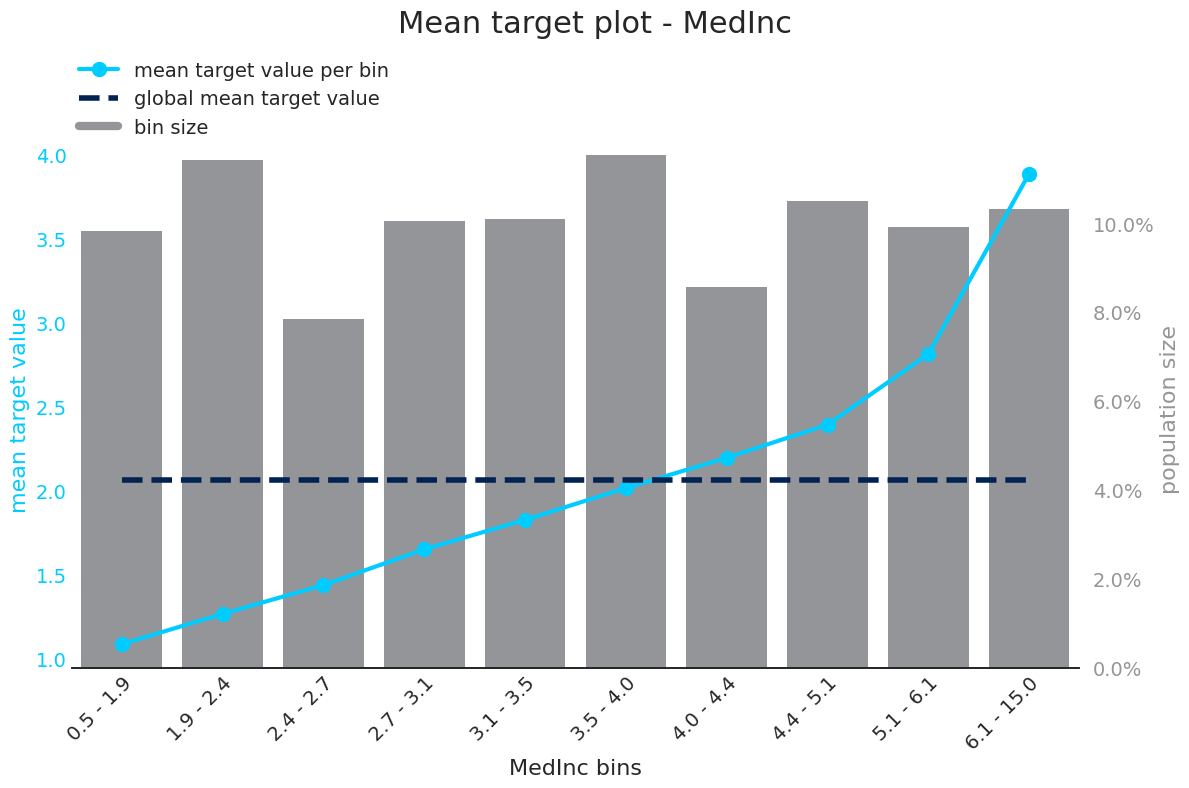

In [17]:
col_order = list(basetable["MedInc_bin"].unique().sort_values())
plot_incidence(pig_tables, variable="MedInc", model_type=model_type, column_order=col_order)

## Feature selection

Once the predictors are properly prepared, we can start building a predictive model, which boils down to selecting the right predictors from the dataset to train a model on.

As a dataset typically contains many predictors, **we first perform a univariate preselection** to rule out any predictor with little to no predictive power. 

Later, using the list of preselected features, we build a multiple regression model using **forward feature selection** to choose the right set of predictors.

In previous steps, these were the predictors, as preprocessed so far:

In [18]:
preprocessed_predictors = [col for col in basetable.columns if col.endswith(("_bin", "_processed"))]
sorted(preprocessed_predictors)

['AveBedrms_bin',
 'AveOccup_bin',
 'AveRooms_bin',
 'HouseAge_bin',
 'Latitude_bin',
 'Longitude_bin',
 'MedInc_bin',
 'Population_bin']

A univariate selection on the preprocessed predictors is conducted. The thresholds for retaining a feature can be changed by the user, for instance both at 2 for now.

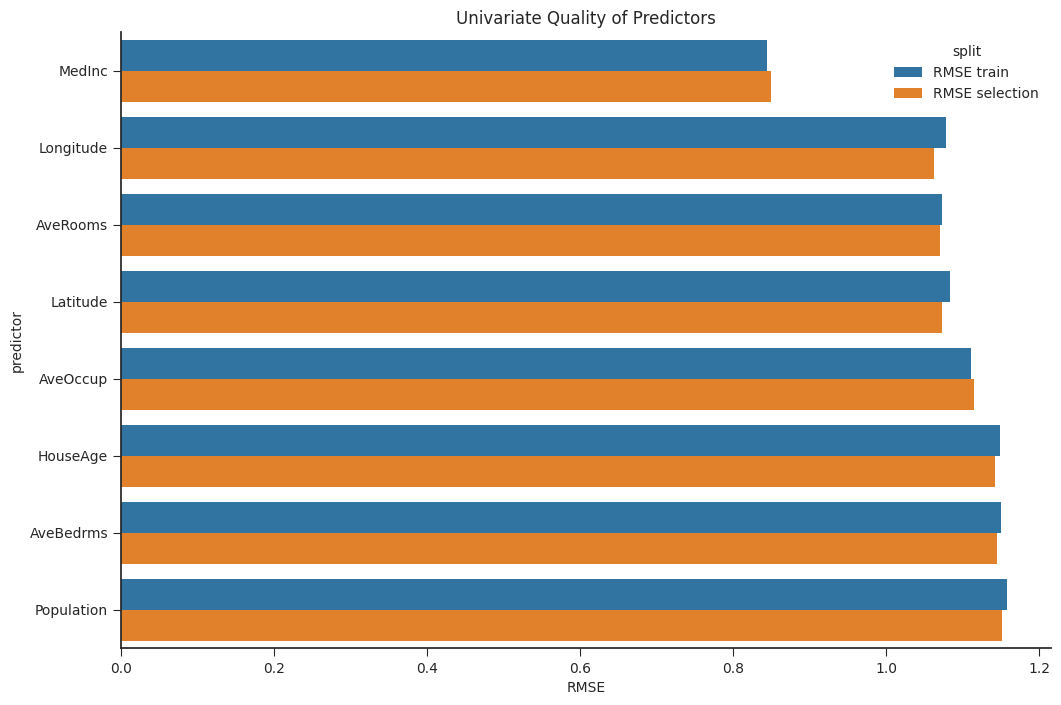

In [19]:
preprocessed_predictors = [col for col in basetable.columns.tolist() if "_enc" in col]

df_rmse = univariate_selection.compute_univariate_preselection(
    target_enc_train_data=basetable[basetable["split"]=="train"],
    target_enc_selection_data=basetable[basetable["split"]=="selection"],
    predictors=preprocessed_predictors,
    target_column=target_col,
    model_type=model_type,
    preselect_rmse_threshold=2, # max. RMSE for selection
    preselect_overtrain_threshold=2) # difference between RMSE on train and selection set

# as the square root of a variance, RMSE can be interpreted as the standard deviation of 
# the unexplained variance, and has the useful property of being in the same unit as the response variable
# lower values of RMSE indicate better fit

plot_univariate_predictor_quality(df_rmse)

Next, we compute correlations between the preprocessed predictors and plot it using a correlation matrix.

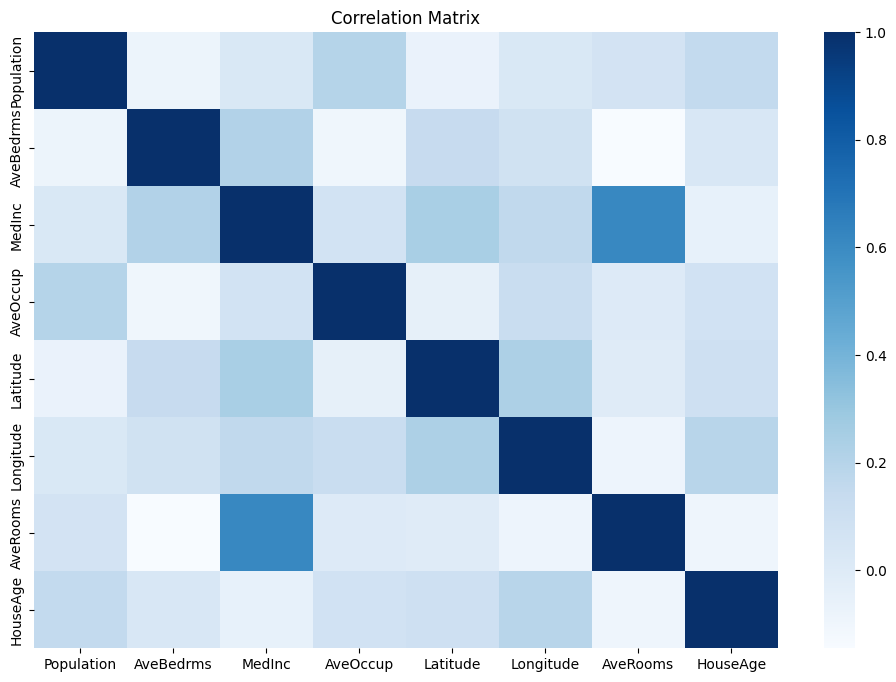

In [20]:
# compute correlations between preprocessed predictors
df_corr = (
    univariate_selection
    .compute_correlations(basetable[basetable["split"]=="train"], preprocessed_predictors)
)
    
# plot correlation matrix
plot_correlation_matrix(df_corr)

To get a list of the selected predictors after the univariate selection, run the following cell.

In [21]:
preselected_predictors = univariate_selection.get_preselected_predictors(df_rmse)
preselected_predictors

['MedInc_enc',
 'Longitude_enc',
 'AveRooms_enc',
 'Latitude_enc',
 'AveOccup_enc',
 'HouseAge_enc',
 'AveBedrms_enc',
 'Population_enc']

## Modelling

After an initial preselection on the predictors, we can start building the model itself using forward feature selection to choose the right set of predictors. Since we use target encoding on all our predictors, we will only consider models with positive coefficients (no sign flip should occur) as this makes the model more interpretable.

In [22]:
forward_selection = ForwardFeatureSelection(
    model_type=model_type,
    # model_name="my-linear-regression",
    pos_only=True
)

# fit the forward feature selection on the train and selection data
# there are optional parameters to force and/or exclude certain predictors (see docs)
forward_selection.fit(
    basetable[basetable["split"]!="validation"],
    target_column_name=target_col,
    predictors=preselected_predictors
)

# compute model performance
performances = (
    forward_selection
    .compute_model_performances(basetable, target_column_name=target_col)
)

# One can also use a different metric
# performances = (
#     forward_selection
#     .compute_model_performances(basetable, target_column_name=target_col, metric=metrics.r2_score)
# )
performances

Sequentially adding best predictor...:   0%|          | 0/8 [00:00<?, ?it/s]/home/jano/anaconda3/envs/tutorial/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/jano/anaconda3/envs/tutorial/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/jano/anaconda3/envs/tutorial/lib/python3

,predictors,last_added_predictor,train_performance,selection_performance,validation_performance,model_type
0,[MedInc_enc],MedInc_enc,0.844041,0.849535,0.858740,regression
1,"[MedInc_enc, Longitude_enc]",Longitude_enc,0.787545,0.781405,0.797729,regression
2,"[MedInc_enc, Longitude_enc, AveOccup_enc]",AveOccup_enc,0.749483,0.749779,0.757353,regression
3,"[AveOccup_enc, Longitude_enc, MedInc_enc, Lati...",Latitude_enc,0.724763,0.721771,0.734818,regression
4,"[AveOccup_enc, Longitude_enc, MedInc_enc, Lati...",HouseAge_enc,0.715711,0.711096,0.728758,regression
5,"[AveOccup_enc, HouseAge_enc, Longitude_enc, Me...",AveRooms_enc,0.714020,0.709073,0.727174,regression


As can be seen, model improvement gradually flattens when more variables are added.

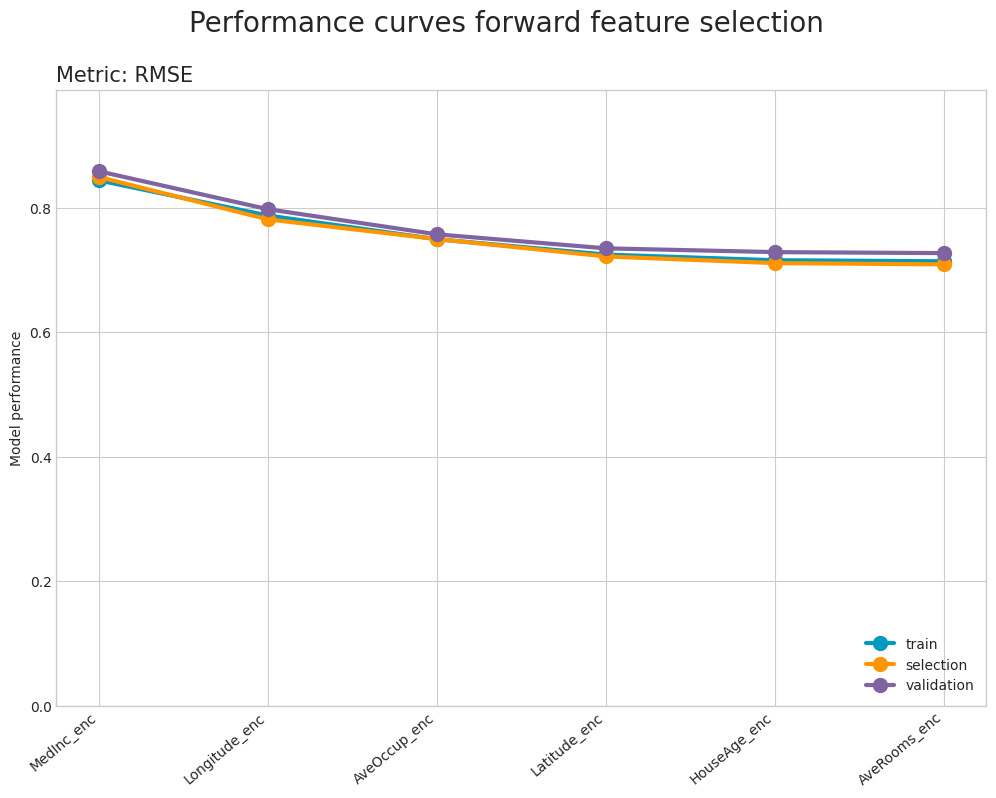

In [23]:
# plot performance curves
plot_performance_curves(performances, metric_name="RMSE")

Based on the performance curves (RMSE per model with a particular number of predictors in case of linear regression), a final model can then be chosen and the variable importance can be plotted.

In [24]:
# pick the optimal step based on visual inspection in the plot above (try to find a knee point in the selection curve)
model = forward_selection.get_model_from_step(4)

final_predictors = model.predictors
final_predictors

['AveOccup_enc', 'Longitude_enc', 'MedInc_enc', 'Latitude_enc', 'HouseAge_enc']

In [25]:
model.get_coef_by_predictor()

{'AveOccup_enc': 0.7656406089511255,
 'Longitude_enc': 0.5033083946065307,
 'MedInc_enc': 0.8828127456416215,
 'Latitude_enc': 0.4651680706216576,
 'HouseAge_enc': 0.7370400932275004}

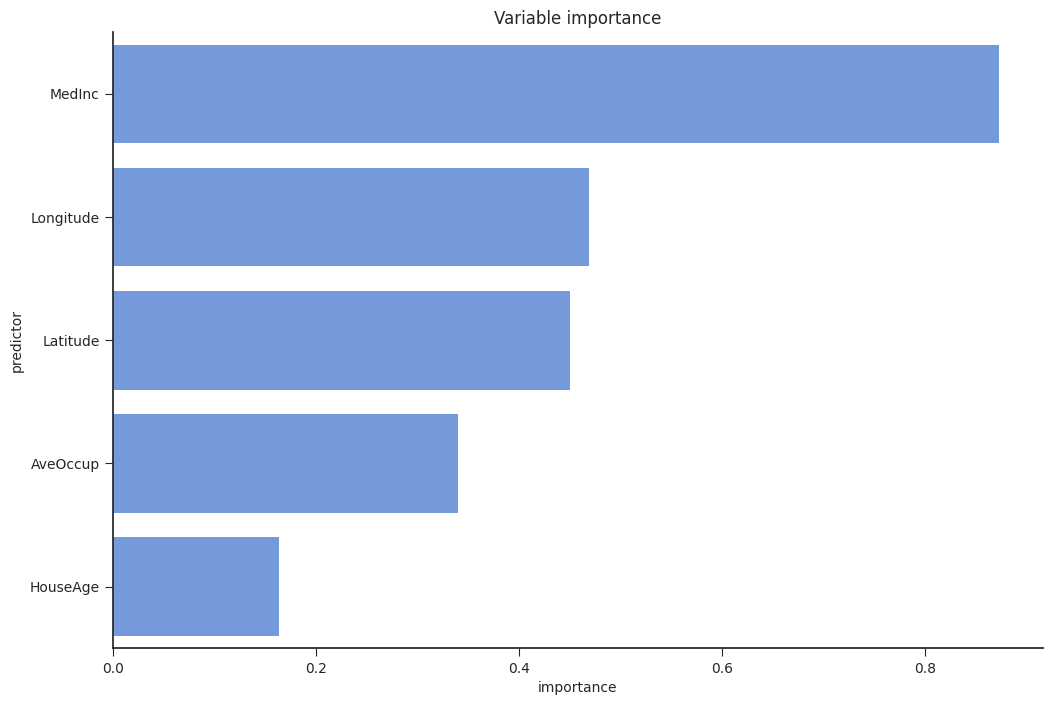

In [26]:
variable_importance = model.compute_variable_importance(
    basetable[basetable["split"]=="selection"])
plot_variable_importance(variable_importance)

**Note**: variable importance is based on correlation of the predictor with the model predictions (and not the true values!).

## Evaluation

Now that we have build and selected a final model, it is time to evaluate its predictions on the test set against various evaluation metrics. The used evaluation metrics are:

1. Coefficient of Determination (R2)
2. Mean Absolute Error (MAE)
3. Mean Squared Error (MSE)
4. Root Mean Squared Error (RMSE)

Furthermore, plotting makes the evaluation of a linear regression model a lot easier. We will use a **prediction plot**, which presents predictions from the model against actual values and a **Q-Q plot** from the standardized prediction residuals.

In [27]:
# get numpy array of True target labels and predicted values
# We will only select the first 100 values to have a more readable plot
y_true = basetable[basetable["split"]=="validation"][target_col].values[:100]
y_pred = model.score_model(basetable[basetable["split"]=="validation"].iloc[:100])

In [28]:
evaluator = RegressionEvaluator()
evaluator.fit(y_true, y_pred)

In [29]:
evaluator.scalar_metrics

R2      0.526515
MAE     0.584941
MSE     0.524415
RMSE    0.724165
dtype: float64

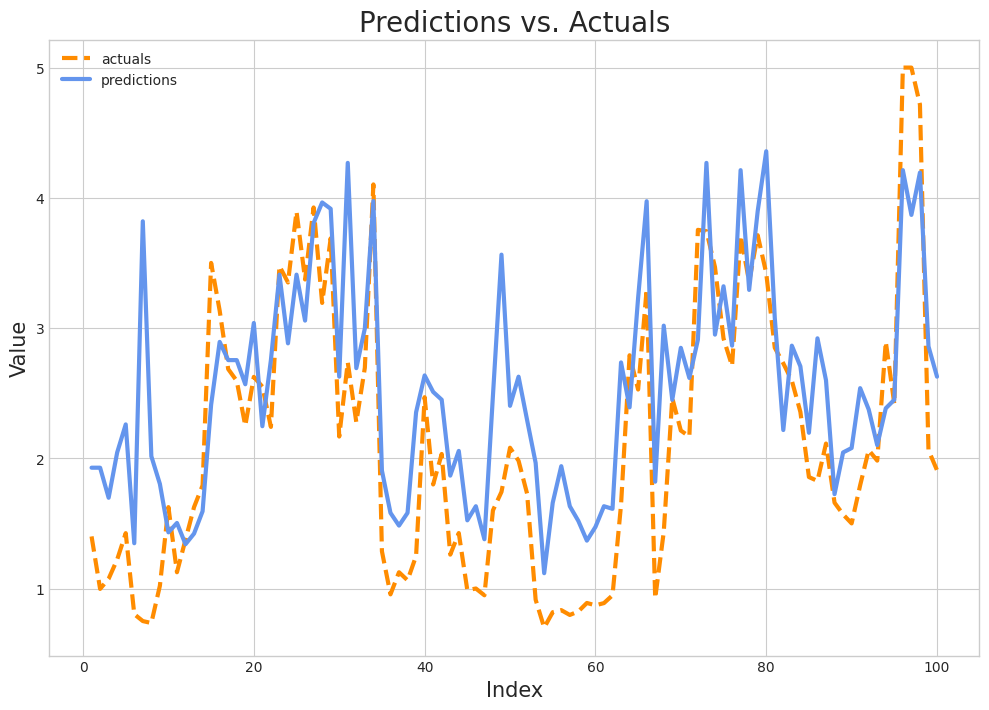

In [30]:
evaluator.plot_predictions()

This helps you only to evaluate the model *a bit*.
To zoom in on the predictions more, particularly on parts of the validation set with low target values, or high target values, etc., check the cells further below.
Adding better support for this in Cobra is on the wishlist for Cobra extensions.

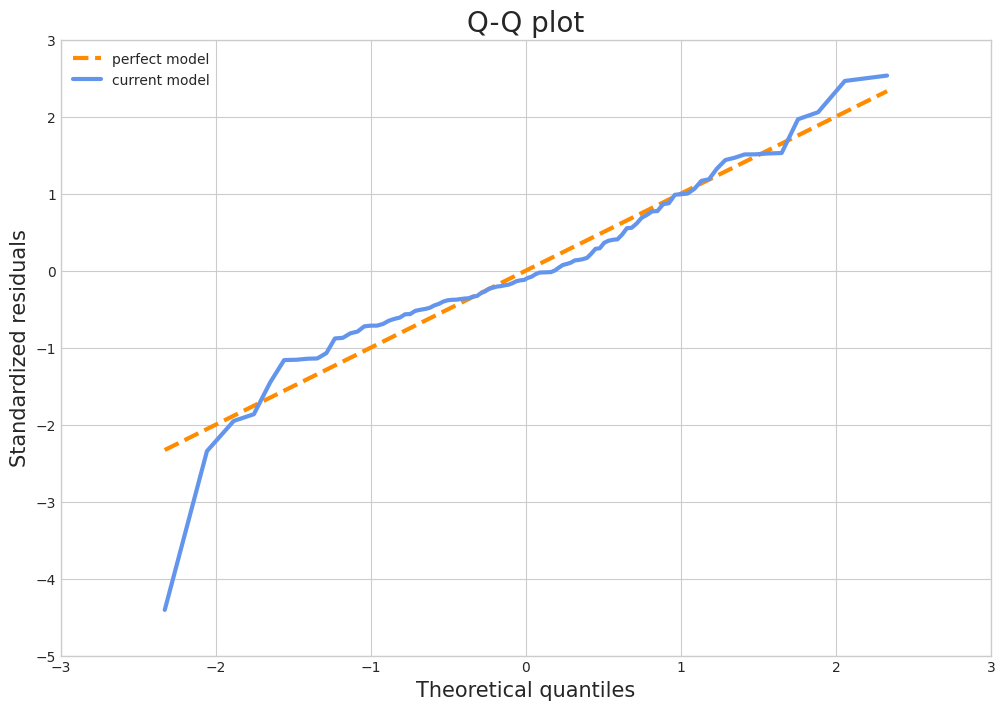

In [31]:
evaluator.plot_qq()

### Zooming in on parts of the (test) dataset

In [32]:
def evaluate_test_set_part(target_min_value, target_max_value):
    validation_set = basetable[basetable["split"]=="validation"]
    
    validation_set_part = validation_set[
        (validation_set[target_col]>=target_min_value) & 
        (validation_set[target_col]<target_max_value)
    ]
    
    # get numpy array of True target labels and predicted values
    y_true_part = validation_set_part[target_col].values
    y_pred_part = model.score_model(validation_set_part)
    
    evaluator_partly = RegressionEvaluator()
    evaluator_partly.fit(y_true_part, y_pred_part)
    
    print(evaluator_partly.scalar_metrics)
    evaluator_partly.plot_predictions()
    evaluator_partly.plot_qq()

R2     -0.945253
MAE     0.466419
MSE     0.342376
RMSE    0.585129
dtype: float64


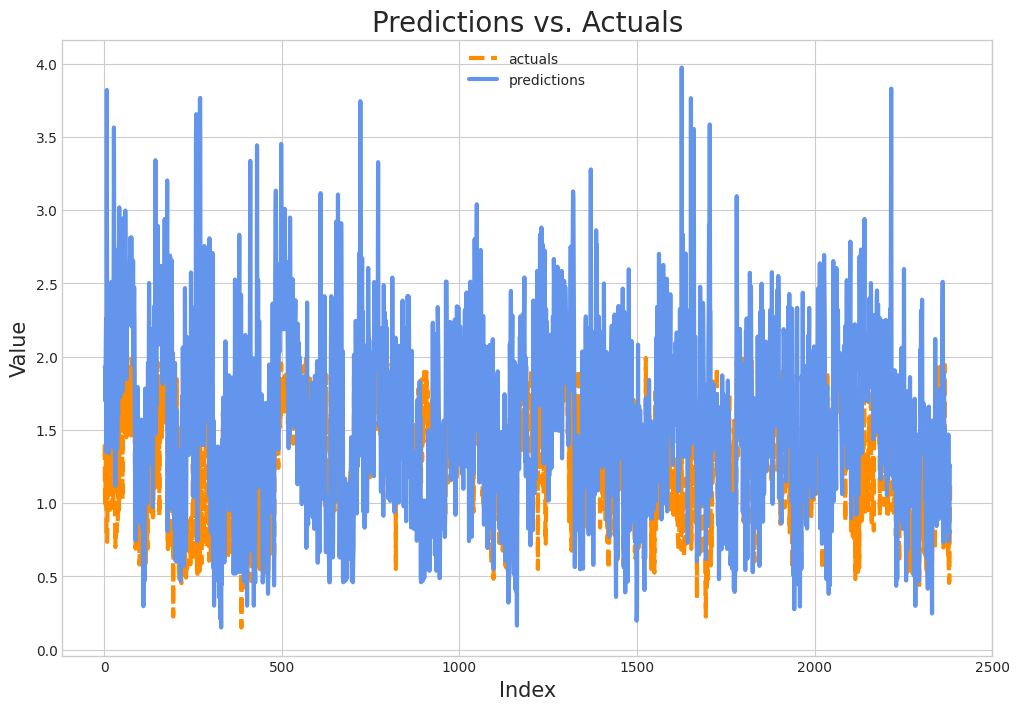

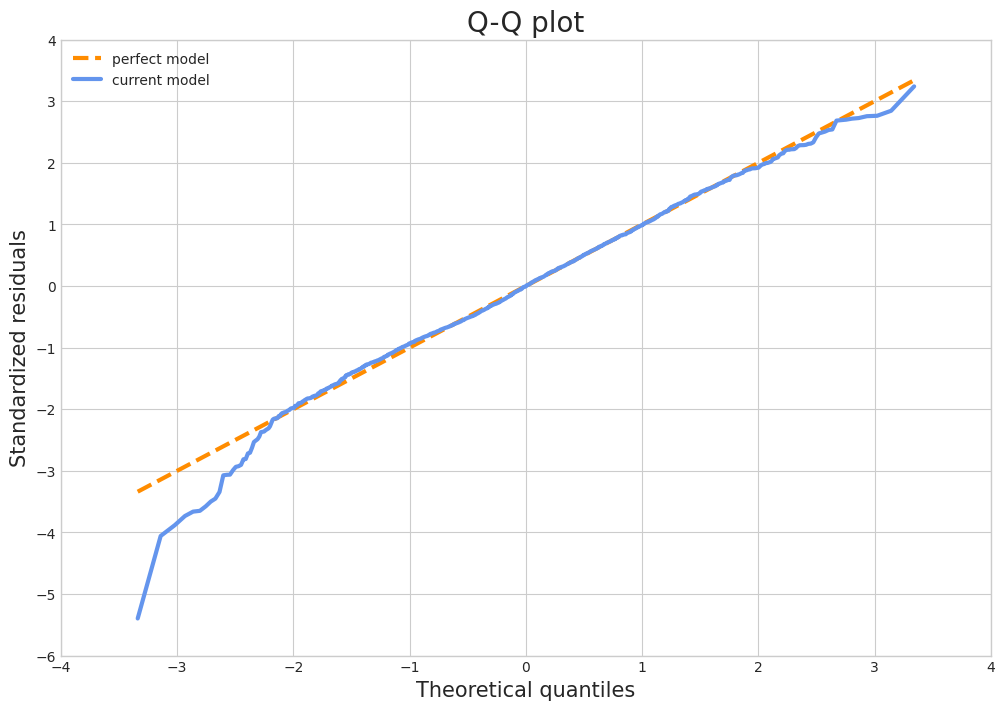

In [33]:
evaluate_test_set_part(target_min_value=0, target_max_value=2)

R2     -0.576730
MAE     0.523495
MSE     0.467165
RMSE    0.683494
dtype: float64


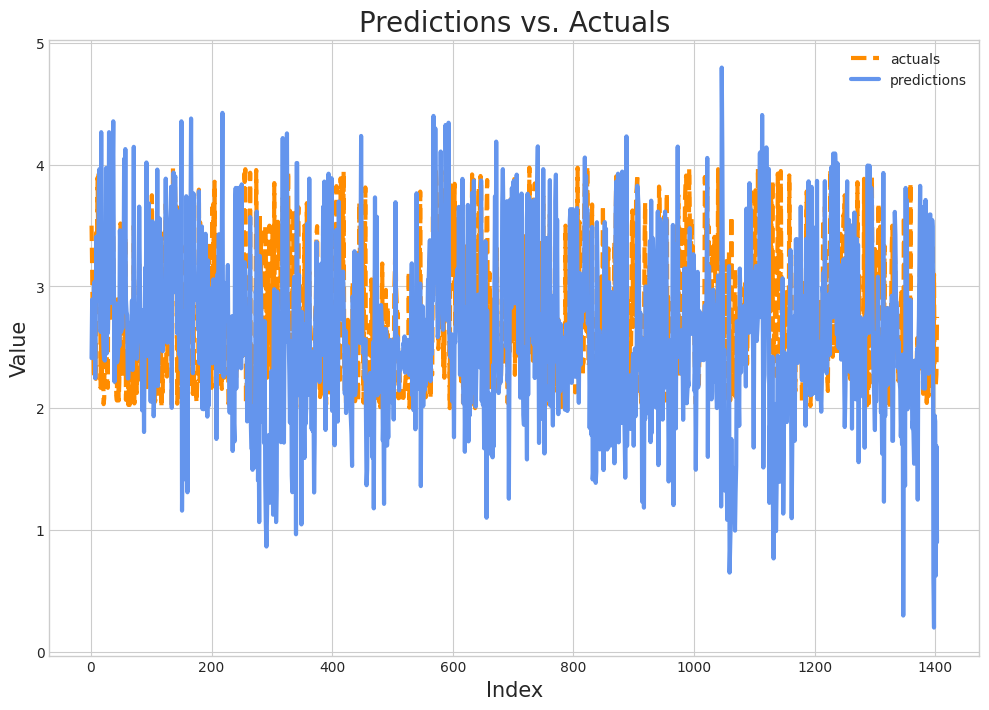

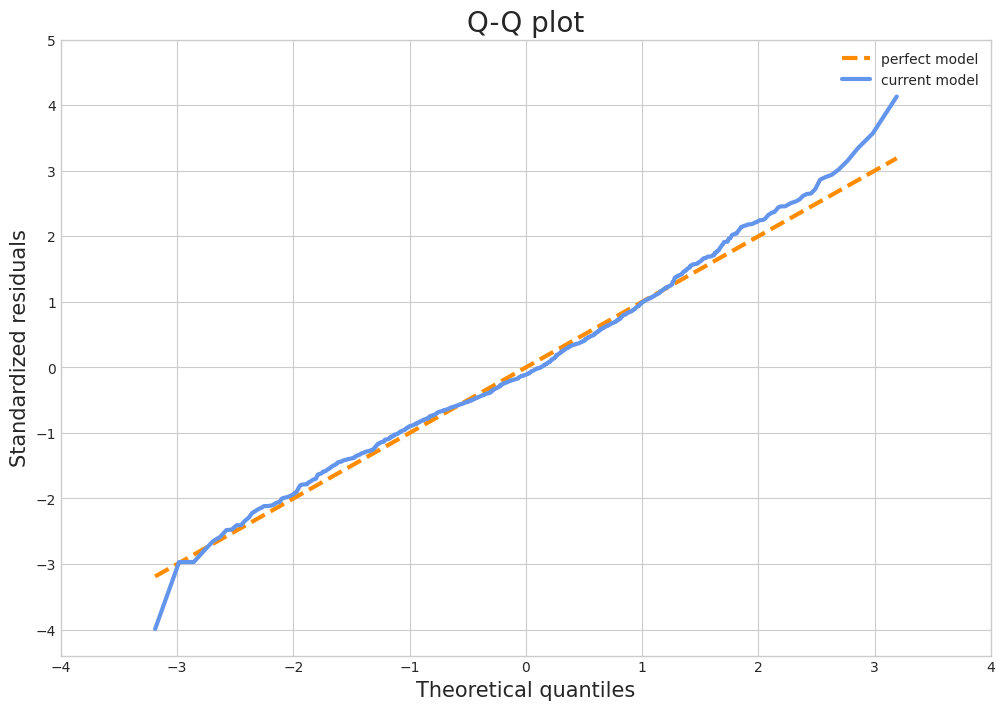

In [34]:
evaluate_test_set_part(target_min_value=2, target_max_value=4)

R2     -17.442097
MAE      1.248843
MSE      2.103088
RMSE     1.450203
dtype: float64


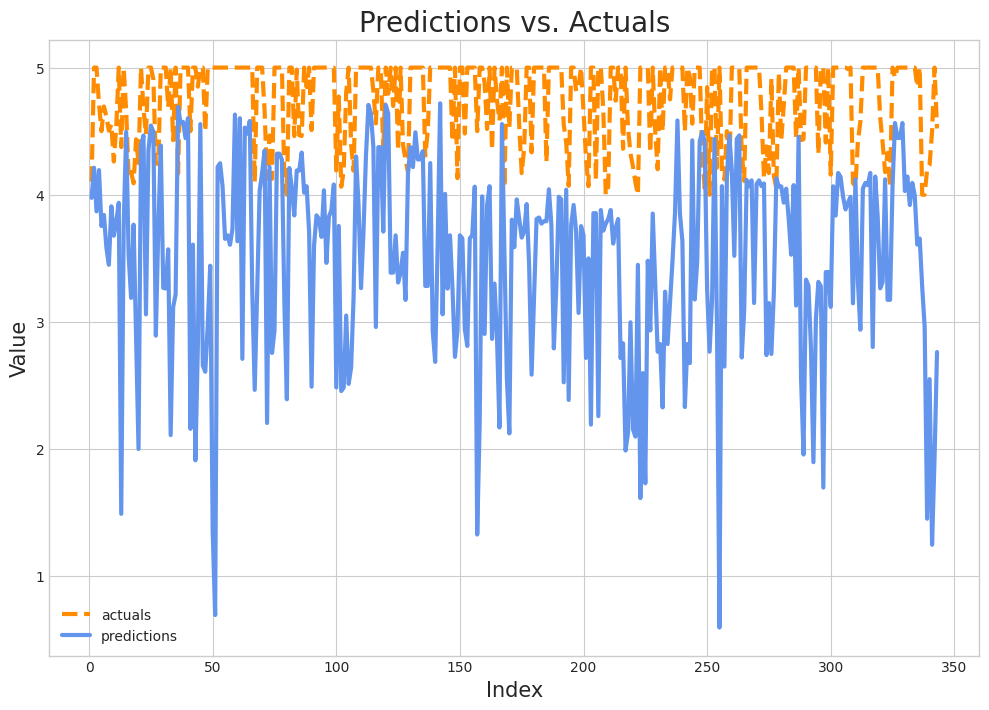

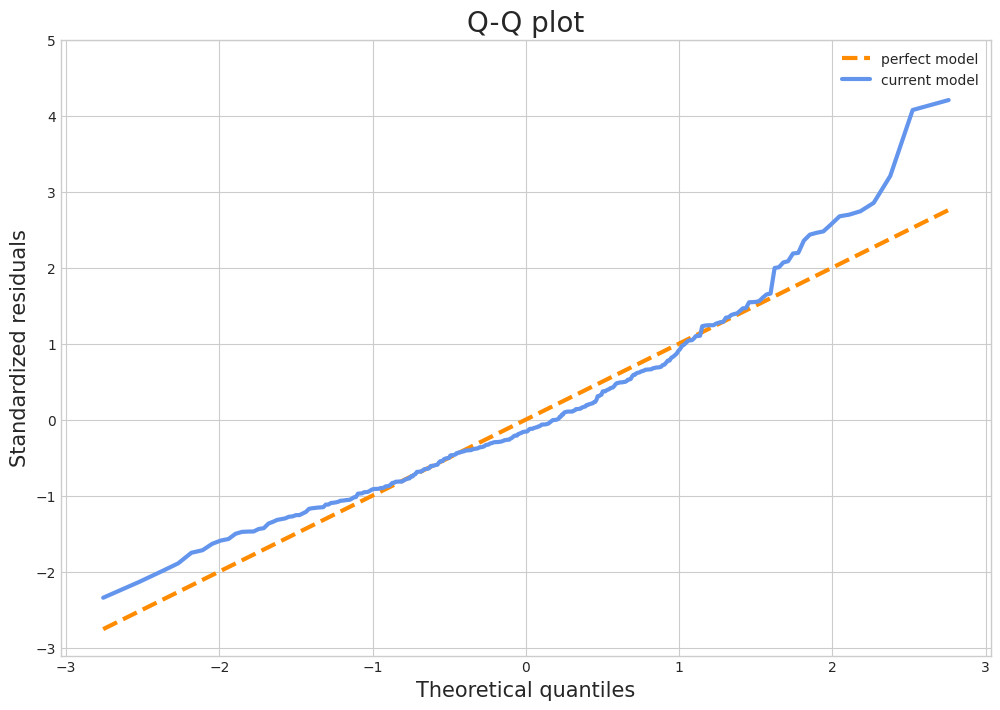

In [35]:
evaluate_test_set_part(target_min_value=4, target_max_value=6)

## Industrialization

Finally, if wanted, we can convert the model to a dictionary to store it as JSON.

In [36]:
model_dict = model.serialize()
model_dict

{'meta': 'linear-regression',
 'predictors': ['AveOccup_enc',
  'Longitude_enc',
  'MedInc_enc',
  'Latitude_enc',
  'HouseAge_enc'],
 '_eval_metrics_by_split': {'selection': 0.7110956210144433,
  'train': 0.7157113945355812,
  'validation': 0.7287579344214824},
 'params': {'copy_X': True,
  'fit_intercept': True,
  'n_jobs': None,
  'normalize': False,
  'positive': False},
 'coef_': [0.7656406089511255,
  0.5033083946065307,
  0.8828127456416215,
  0.4651680706216576,
  0.7370400932275004],
 'intercept_': -4.864713349831583}

In [37]:
if False: # enable this again when you need to industrialize your model.
    # to save the model as a JSON file, run the following snippet
    model_path = os.path.join("output", "model.json")
    with open(model_path, "w") as file:
        json.dump(model_dict, file)

    # to reload the model again from a JSON file, run the following snippet
    with open(model_path, "r") as file:
        model_dict = json.load(file)
    model = LinearRegressionModel()
    model.deserialize(model_dict)